Example using ims data and encoder defined slews

Start by querying 'lsst.sal.MTMount.elevation' for encoder positions and 'lsst.sal.MTM1M3.imsData' for mirror xyz positons 

we import `get_slews_edge_detection` and `get_slew_pairs` from `identify_slews.py` to create a list of slews. 



In [1]:
import sys, time, os, asyncio, glob
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pickle as pkl
from astropy.time import Time, TimezoneInfo, TimeDelta
from astropy import units as u

from scipy.interpolate import UnivariateSpline
from lsst_efd_client import EfdClient

from scipy.interpolate import interp1d

from lsst.sitcom import vandv
from lsst.ts.idl.enums import MTM1M3
import importlib

In [2]:
plt.rcParams["xtick.direction"]='in'
plt.rcParams["ytick.direction"]='in'

# Query Data

In [3]:
client = EfdClient('usdf_efd')
# Now let's try to expand it to the whole run
date="2023-05-31"
t_start = Time(f"{date}T07:22:00", scale='utc')

window = TimeDelta(1.2 * 60 * 60, format='sec') #4 * 60

t_start = t_start + window

t_end = t_start + window
#start=start + TimeDelta(20, format='sec')

In [5]:
mtmount=await client.select_time_series('lsst.sal.MTMount.elevation', \
                                ["*"],  t_start, t_end)
starts,stops=vandv.mount.get_slew_from_mtmount(mtmount)

> /home/p/pferguso/u/repos/sitcom/notebooks_vandv/python/lsst/sitcom/vandv/mount.py(201)get_slews_edge_detection_telemetry()
    199     maxv = []
    200     import pdb; pdb.set_trace()
--> 201     starts, stops = get_slew_pairs(starts, stops)
    202 
    203     for i, st in enumerate(starts):



ipdb>  c


In [6]:
df_hp=await client.select_time_series( "lsst.sal.MTM1M3.hardpointActuatorData", \
                                      ["*"],  t_start, t_end)

In [7]:
all_columns = ["xPosition", "xRotation", "yPosition", "yRotation", "zPosition", "zRotation"]
pos_columns = [c for c in all_columns if "Position" in c]
rot_columns = [c for c in all_columns if "Rotation" in c]

df_ims = await client.select_time_series(
    "lsst.sal.MTM1M3.imsData", 
    "*", 
    Time(t_start, format="isot", scale="utc"),
    Time(t_end, format="isot", scale="utc"), 
)

df_ims = df_ims.set_index("private_rcvStamp")
df_ims.index = pd.to_datetime(df_ims.index, unit="s")
df_ims = df_ims#[all_columns]

# Convert meter to milimeter to make is easier to analyse
df_ims[pos_columns] = df_ims[pos_columns] * 1e3

# Convert radians to degrees
df_ims[rot_columns] = np.rad2deg(df_ims[rot_columns])

# Identify slews
important note these timestamps are in tai time and the dataframe indexes are not

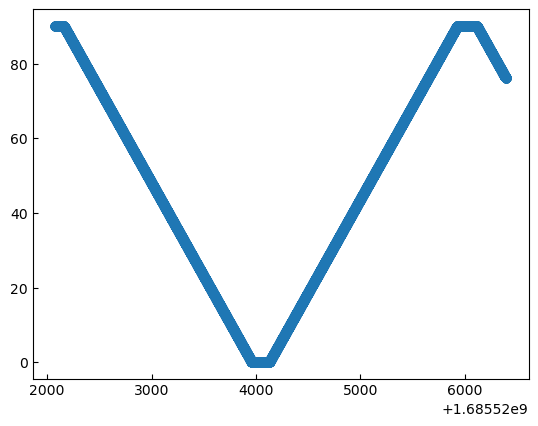

In [8]:
plt.scatter(mtmount["timestamp"], mtmount["actualPosition"])

In [35]:
importlib.reload(vandv)

<module 'lsst.sitcom.vandv' from '/home/p/pferguso/u/repos/sitcom/notebooks_vandv/python/lsst/sitcom/vandv/__init__.py'>

In [9]:
starts,stops =vandv.mount.get_slew_from_mtmount(mtmount)
#starts,stops = vandv.mount.get_slew_pairs(starts,stops)

> /home/p/pferguso/u/repos/sitcom/notebooks_vandv/python/lsst/sitcom/vandv/mount.py(201)get_slews_edge_detection_telemetry()
    199     maxv = []
    200     import pdb; pdb.set_trace()
--> 201     starts, stops = get_slew_pairs(starts, stops)
    202 
    203     for i, st in enumerate(starts):



ipdb>  c


get timestamps for two dataframes in a similar format

In [10]:
starts

array([1.68552212e+09, 1.68552409e+09])

In [11]:
ims_times=Time(df_ims.index).unix
mtmount_times=Time(mtmount.index).unix
hp_times=Time(df_hp.index).unix

# plot 10 slews

In [16]:
from scipy.interpolate import interp1d

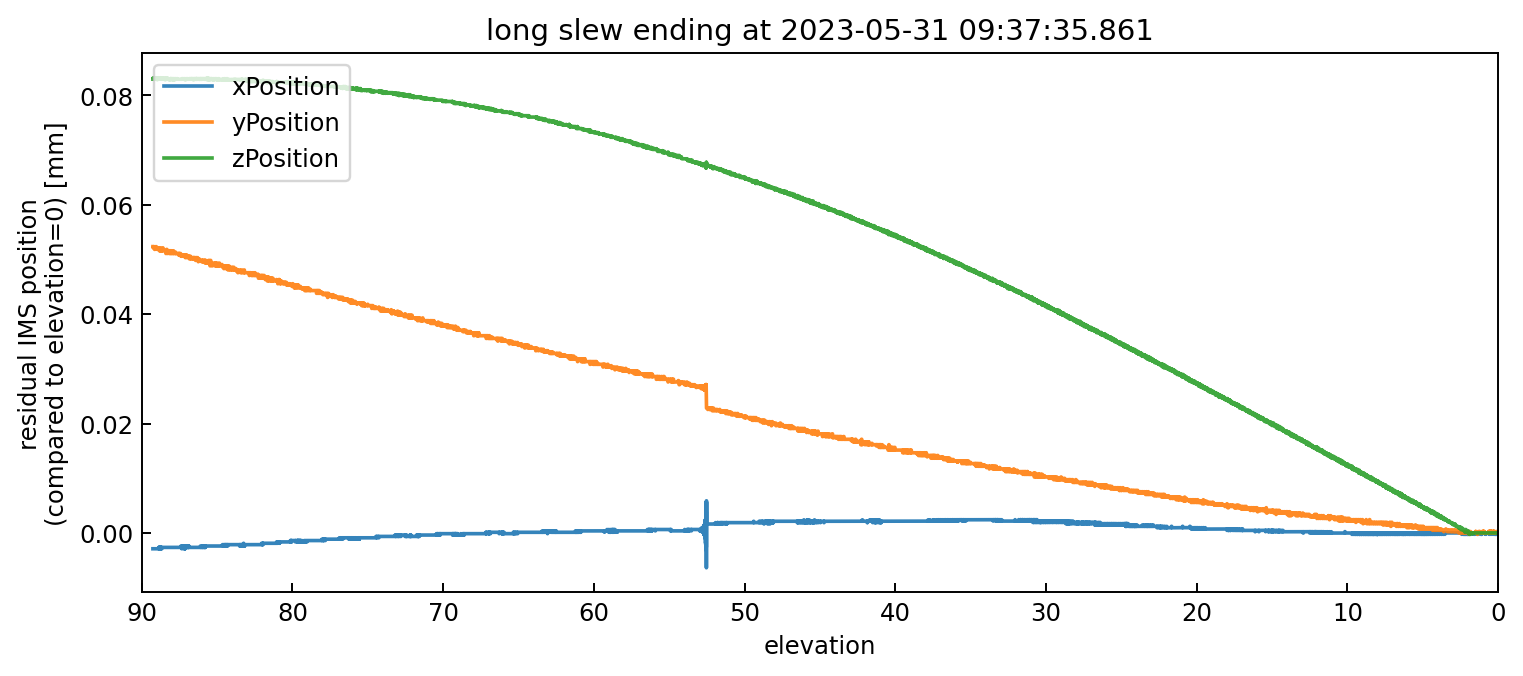

In [34]:
position_interp=interp1d(mtmount_times[sel_mt]-end1, subframe_mt["actualPosition"], bounds_error=False)
offset= 0.00#3
plt.figure(dpi=175, figsize=(10,4))
for i, col in enumerate(["xPosition","yPosition","zPosition",
                         # "rawSensorData0","rawSensorData1",
                         # "rawSensorData2","rawSensorData3",
                         # "rawSensorData4","rawSensorData5",
                         # "rawSensorData6"
                        ]):
    plt.plot(position_interp(ims_times[sel_ims]-end1),subframe_ims[col].rolling(1).mean() - subframe_ims[col][np.argmin(abs(ims_times[sel_ims]-s1))] - i * offset , 
         label=f"{col}", alpha=0.9)
plt.xlim(90,0)
plt.xlabel("elevation")
plt.ylabel("residual IMS position\n(compared to elevation=0) [mm]")
plt.title(f"long slew ending at {Time(end1, format='unix_tai').iso}")
plt.legend(loc=2)

11


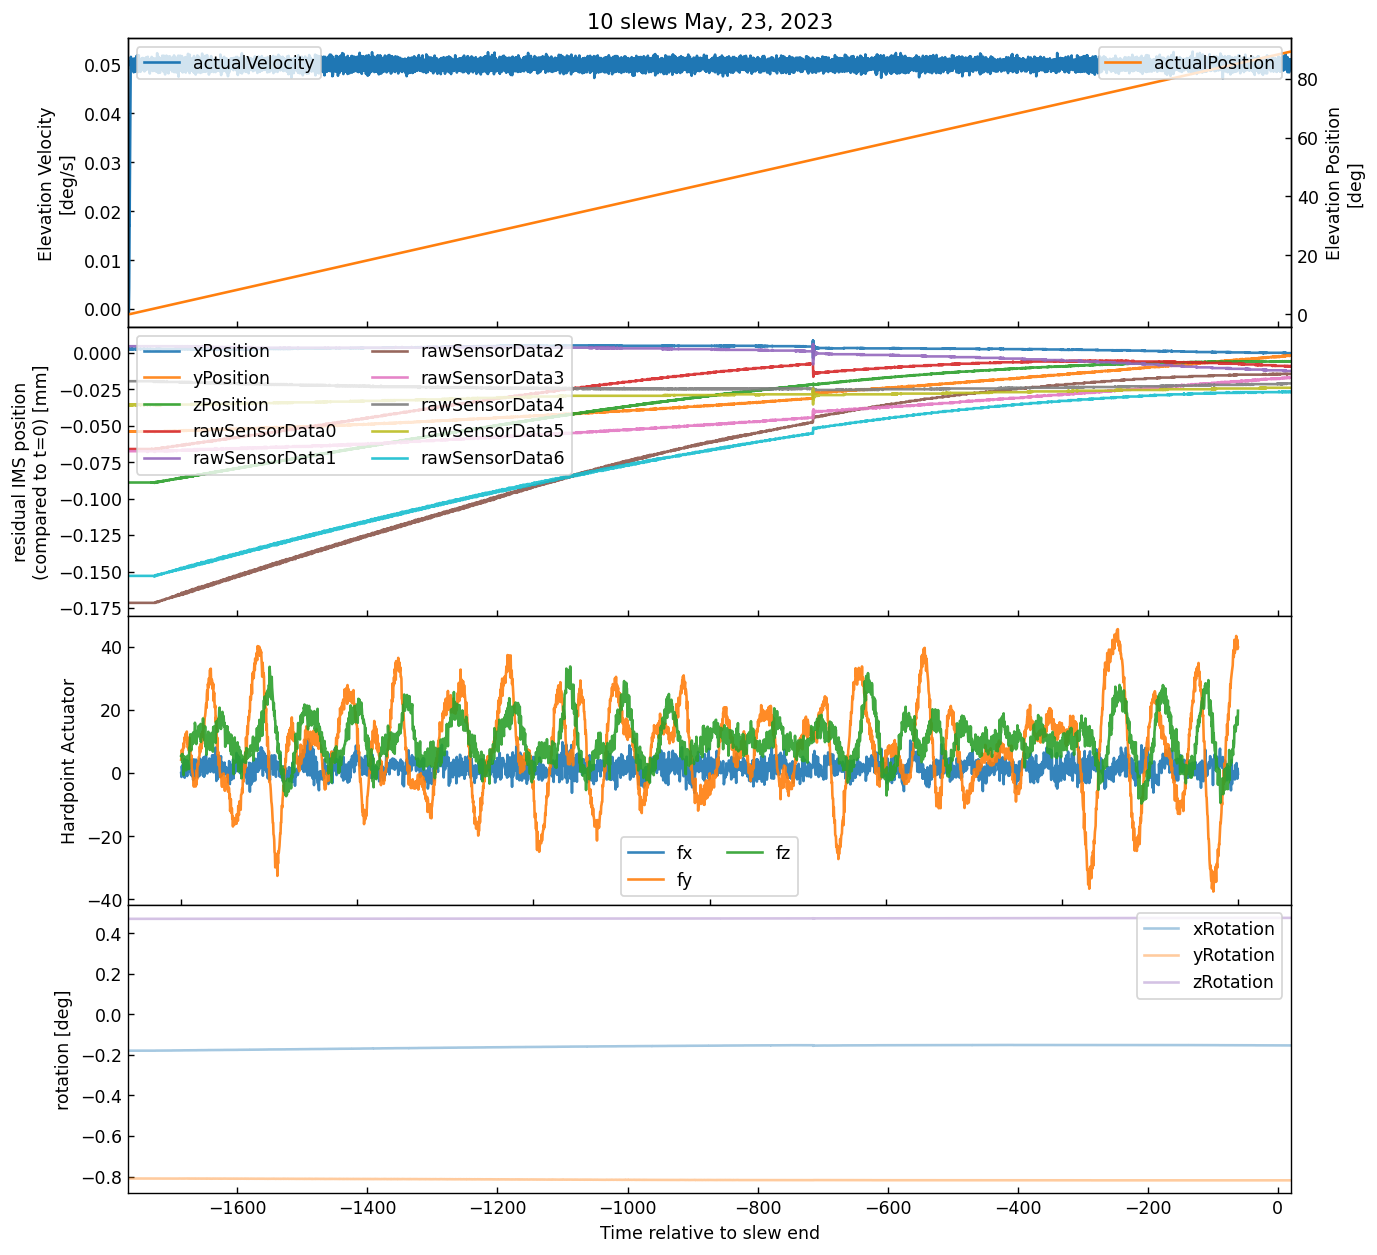

In [29]:
legend_bool=True
mintime=-2.5
maxtime=2.5
fig,axs=plt.subplots(4,1, dpi=125, figsize=(12,12))


for i in range(len(starts)):
    if (i != 1):# | (i>10):# [9,20,8, 21, 19, 31, 28]: 
        continue
    

    
    mintime=s1-end1
    maxtime=20
    s1=starts[i]
    end1=stops[i]
    end1=Time(end1, format="unix_tai").unix
    sel_ims= (ims_times > end1 + mintime) & (ims_times < end1 + 20)
    sel_mt= (mtmount_times > end1  +mintime) & (mtmount_times < end1 + 20)
    sel_hp= (hp_times > end1 - 40) & (hp_times < end1 + 20)
    
    subframe_mt=mtmount[sel_mt]
    subframe_ims=df_ims[sel_ims]
    subframe_hp=df_hp[sel_hp]
    
    ax=axs[0]
    ax.set_title("10 slews May, 23, 2023") 
    ax.plot(mtmount_times[sel_mt]-end1, subframe_mt["actualVelocity"], c="tab:blue", label="actualVelocity")
    ax.set_xlim(mintime,maxtime)
    ax.set_xticklabels([])
    ax.set_ylabel("Elevation Velocity\n[deg/s]")
    ax.legend(loc=2)
    #mval=np.abs(subframe_mt["actualVelocity"].max())
    #ax.set_ylim(-1*mval,mval)
    
    ax2 = ax.twinx()
    ax2.set_xlim(mintime,maxtime)
    ax2.set_xticklabels([])
    ax2.set_ylabel("Elevation Position\n[deg]")
    ax2.plot(mtmount_times[sel_mt]-end1, subframe_mt["actualPosition"] - 0 * subframe_mt["actualPosition"][np.argmin(abs(mtmount_times[sel_mt]-end1))],
            c="tab:orange", label="actualPosition")
    #ax.axvline(0,c="k", ls="dashed")
    ax2.legend(loc=1)
    ax=axs[1]
    
    
    #ax.axvline(0,c="k", ls="dashed")
    
    ax.set_xlim(mintime,maxtime)
    ax.set_ylabel("residual IMS position\n(compared to t=0) [mm]")
    
    offset= 0.003
    for i, col in enumerate(["xPosition","yPosition","zPosition",
                             "rawSensorData0","rawSensorData1",
                             "rawSensorData2","rawSensorData3",
                             "rawSensorData4","rawSensorData5",
                             "rawSensorData6"]):
        ax.plot(ims_times[sel_ims]-end1,subframe_ims[col].rolling(1).mean() - subframe_ims[col][np.argmin(abs(ims_times[sel_ims]-end1))] - i * offset , 
             label=f"{col}", alpha=0.9)
    
#     ax.plot(ims_times[sel_ims]-end1,subframe_ims["yPosition"].rolling(1).mean() - subframe_ims["yPosition"][np.argmin(abs(ims_times[sel_ims]-end1))], 
#              label=f"yPosition", c="tab:orange", alpha=0.4)
#     ax.plot(ims_times[sel_ims]-end1,subframe_ims["zPosition"].rolling(1).mean() - subframe_ims["zPosition"][np.argmin(abs(ims_times[sel_ims]-end1))] - 0.005, 
#              label=f"zPosition - 0.005", c="tab:purple", alpha=0.4)
    
#     ax.plot(ims_times[sel_ims]-end1, subframe_ims["rawSensorData1"] - subframe_ims["rawSensorData1"][np.argmin(abs(ims_times[sel_ims]-end1))] - 0.01, 
#             label=f"zPosition - 0.005", c="tab:green", alpha=0.4)
    #ax.plot( subframe_ims[
    
    #ax.axvline(0,c="k", ls="dashed")
    print(len(ax.xaxis.get_major_ticks()))
    if legend_bool:
        #legend_bool=False
        ax.legend(loc=2, ncol=2)
    #ax.set_yscale('log')
    #ax.set_ylim(-0.01, 0.01)
    ax=axs[2]
    for i, col in enumerate(["fx","fy","fz"]):
        ax.plot(hp_times[sel_hp]-end1,subframe_hp[col].rolling(1).mean() - subframe_hp[col][np.argmin(abs(hp_times[sel_hp]-end1))] - i * offset , 
             label=f"{col}", alpha=0.9)
    if legend_bool:
        #legend_bool=False
        ax.legend(loc=0, ncol=2)
    ax.set_ylabel("Hardpoint Actuator")
    ax=axs[3]
    ax.set_xlim(mintime,maxtime)
    ax.set_ylabel("rotation [deg]")
    subframe_ims=df_ims[sel_ims]
    ax.plot(ims_times[sel_ims]-end1,subframe_ims["xRotation"] , 
             label=f"xRotation", c="tab:blue", alpha=0.4)
    ax.plot(ims_times[sel_ims]-end1,subframe_ims["yRotation"] , 
             label=f"yRotation", c="tab:orange", alpha=0.4)
    ax.plot(ims_times[sel_ims]-end1,subframe_ims["zRotation"] , 
             label=f"zRotation", c="tab:purple", alpha=0.4)
    #ax.axvline(0,c="k", ls="dashed")
    ax.set_xlabel("Time relative to slew end")
    ax.legend()
plt.subplots_adjust(hspace=0)

7

In [ ]:
legend_bool=True
mintime=-2.5
maxtime=2.5
fig,axs=plt.subplots(4,1, dpi=125, figsize=(12,8))


for i in range(len(starts)):
    if (i > 0) | (i>10):# [9,20,8, 21, 19, 31, 28]: 
        continue
    
    s1=starts[i]
    end1=stops[i]
    end1=Time(end1, format="unix_tai").unix
    sel_ims= (ims_times > end1 - 40) & (ims_times < end1 + 20)

    sel_mt= (mtmount_times > end1  - 40) & (mtmount_times < end1 + 20)
    subframe_mt=mtmount[sel_mt]
    ax=axs[0]
    ax.set_title("10 slews May, 23, 2023") 
    ax.plot(mtmount_times[sel_mt]-end1, subframe_mt["actualVelocity"].rolling(10).mean())
    ax.set_xlim(mintime,maxtime)
    ax.set_xticklabels([])
    ax.set_ylabel("Elevation Velocity\n[deg/s]")
    
    ax2 = ax.twinx()
    ax2.set_xlim(mintime,maxtime)
    ax2.set_xticklabels([])
    ax2.set_ylabel("Elevation Position\n[deg]")
    ax2.plot(mtmount_times[sel_mt]-end1, subframe_mt["actualPosition"]-subframe_mt["actualPosition"][np.argmin(abs(mtmount_times[sel_mt]-end1))])
    #ax.axvline(0,c="k", ls="dashed")
    ax=axs[1]
    
    
    #ax.axvline(0,c="k", ls="dashed")
    ax=axs[2]
    ax.set_xlim(mintime,maxtime)
    ax.set_ylabel("rolling mean 10\nIMS positions [mm]")
    subframe_ims=df_ims[sel_ims]
    ax.plot(ims_times[sel_ims]-end1,subframe_ims["xPosition"].rolling(1).mean() - subframe_ims["xPosition"][np.argmin(abs(ims_times[sel_ims]-end1))] + 0.005 , 
             label=f"xPosition + 0.005", c="tab:blue", alpha=0.4)
    ax.plot(ims_times[sel_ims]-end1,subframe_ims["yPosition"].rolling(1).mean() - subframe_ims["yPosition"][np.argmin(abs(ims_times[sel_ims]-end1))], 
             label=f"yPosition", c="tab:orange", alpha=0.4)
    ax.plot(ims_times[sel_ims]-end1,subframe_ims["zPosition"].rolling(1).mean() - subframe_ims["zPosition"][np.argmin(abs(ims_times[sel_ims]-end1))] - 0.005, 
             label=f"zPosition - 0.005", c="tab:purple", alpha=0.4)
    #ax.axvline(0,c="k", ls="dashed")
    if legend_bool:
        legend_bool=False
        ax.legend(loc=1)
    #ax.set_yscale('log')
    ax.set_ylim(-0.01, 0.01)
    
    ax=axs[3]
    ax.set_xlim(mintime,maxtime)
    ax.set_ylabel("rolling std 100\nIMS positions [mm]")
    subframe_ims=df_ims[sel_ims]
    ax.plot(ims_times[sel_ims]-end1,subframe_ims["xPosition"].rolling(500).std()  , 
             label=f"xPosition", c="tab:blue", alpha=0.4)
    ax.plot(ims_times[sel_ims]-end1,subframe_ims["yPosition"].rolling(500).std() , 
             label=f"yPosition", c="tab:orange", alpha=0.4)
    ax.plot(ims_times[sel_ims]-end1,subframe_ims["zPosition"].rolling(500).std() , 
             label=f"zPosition", c="tab:purple", alpha=0.4)
    #ax.axvline(0,c="k", ls="dashed")
    ax.set_yscale('log')
    ax.set_xlabel("Time relative to slew end")
plt.subplots_adjust(hspace=0)